# Aircraft Turnaround Activity Modelling and Simulation

In [2]:
pip install simpy

Note: you may need to restart the kernel to use updated packages.


## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import simpy
import random
import seaborn as sns
import matplotlib.pyplot as plt

## Load Dataset & Small Cleaning

### About the Dataset

This data set is a sample of daily schedule of aircraft arrival and departure reflecting a busy day taken from an Airport in UK. As you can see the dataset might contains some columns that reflect prior preprocessing but for now we will just pay our attention to columns as I describe in the following:

+ number: id of the aircraft schedule
+ type: type of the aircraft body by Airbus
+ Airline: name of the aircraft's owning Airline
+ Company: name of the ground handling services company responsible for aircraft
+ ATIME: Scheduled Arrival time in datetime format
+ DTIME: Scheduled Departure time in datetime format
+ preferredStand: preferred id stand for aircraft to do the turnaround
+ fueling: boolean of whether the aircraft would need refueling or not
+ catering: boolean of whether the aircraft would need recatering or not
+ cleaning: boolean of whether the aircraft would need recleaning or not
+ ambulift: boolean of whether the aircraft would need ambulift support for Passanger with reduced mobility (PRM)  or not
+ prm: type of service related to the presence of prm passanger
+ inboundPax: Inbound passenger
+ inboundBag: inbound bag in number
+ outboundPax: Outbound passenger
+ outboundBag: Outbound bag in number



In [2]:
data = pd.read_excel('input_busy_day.xlsx')
data.head()

,number,type,Airline,Company,ATIME,DTIME,SATIME,SDTIME,STA,STD,...,cleaning,ambulift,prm,inboundPax,inboundBag,outboundPax,outboundBag,standChange,priority,day
0,1,A320,Wizz Air,1,07:05:00,07:50:00,425,470,60,105,...,False,False,0,108,92,119,101,0,1,1
1,2,A320,Wizz Air,1,07:05:00,07:35:00,425,455,60,90,...,False,False,0,89,69,86,66,0,1,1
2,3,A321,Wizz Air,1,07:05:00,07:40:00,425,460,60,95,...,False,False,0,124,114,101,94,0,1,1
3,4,A320,Vueling,3,07:10:00,07:55:00,430,475,65,110,...,False,False,0,98,90,86,80,0,1,1
4,5,A320,Wizz Air,1,07:25:00,08:15:00,445,495,80,130,...,False,False,0,116,93,100,80,0,1,1


### Date time to Minutes

In [3]:
def convert_to_minutes(time_obj):
    return time_obj.hour * 60 + time_obj.minute - 360 # -360 as we are opening the airport at suppose 6 in the morning (6*60)

# Apply the function to the 'time' column
data['arrival_time'] = data['ATIME'].apply(convert_to_minutes)
data.head()

,number,type,Airline,Company,ATIME,DTIME,SATIME,SDTIME,STA,STD,...,ambulift,prm,inboundPax,inboundBag,outboundPax,outboundBag,standChange,priority,day,arrival_time
0,1,A320,Wizz Air,1,07:05:00,07:50:00,425,470,60,105,...,False,0,108,92,119,101,0,1,1,65
1,2,A320,Wizz Air,1,07:05:00,07:35:00,425,455,60,90,...,False,0,89,69,86,66,0,1,1,65
2,3,A321,Wizz Air,1,07:05:00,07:40:00,425,460,60,95,...,False,0,124,114,101,94,0,1,1,65
3,4,A320,Vueling,3,07:10:00,07:55:00,430,475,65,110,...,False,0,98,90,86,80,0,1,1,70
4,5,A320,Wizz Air,1,07:25:00,08:15:00,445,495,80,130,...,False,0,116,93,100,80,0,1,1,85


### Convert datetime of departure time to minutes

In [4]:
data['departure_time'] = data['DTIME'].apply(convert_to_minutes)
data.head()

,number,type,Airline,Company,ATIME,DTIME,SATIME,SDTIME,STA,STD,...,prm,inboundPax,inboundBag,outboundPax,outboundBag,standChange,priority,day,arrival_time,departure_time
0,1,A320,Wizz Air,1,07:05:00,07:50:00,425,470,60,105,...,0,108,92,119,101,0,1,1,65,110
1,2,A320,Wizz Air,1,07:05:00,07:35:00,425,455,60,90,...,0,89,69,86,66,0,1,1,65,95
2,3,A321,Wizz Air,1,07:05:00,07:40:00,425,460,60,95,...,0,124,114,101,94,0,1,1,65,100
3,4,A320,Vueling,3,07:10:00,07:55:00,430,475,65,110,...,0,98,90,86,80,0,1,1,70,115
4,5,A320,Wizz Air,1,07:25:00,08:15:00,445,495,80,130,...,0,116,93,100,80,0,1,1,85,135


### Calculate Interarrival time between aircraft schedule

In [5]:
data['interarrival_time'] = data['arrival_time'].diff()

# Fill the first NaN value with 0 or any appropriate value
data['interarrival_time'].fillna(0, inplace=True)

# make the first entry to be equal the first arrival time

data.loc[0, 'interarrival_time'] = data.loc[0, 'arrival_time']

data.head()

,number,type,Airline,Company,ATIME,DTIME,SATIME,SDTIME,STA,STD,...,inboundPax,inboundBag,outboundPax,outboundBag,standChange,priority,day,arrival_time,departure_time,interarrival_time
0,1,A320,Wizz Air,1,07:05:00,07:50:00,425,470,60,105,...,108,92,119,101,0,1,1,65,110,65.0
1,2,A320,Wizz Air,1,07:05:00,07:35:00,425,455,60,90,...,89,69,86,66,0,1,1,65,95,0.0
2,3,A321,Wizz Air,1,07:05:00,07:40:00,425,460,60,95,...,124,114,101,94,0,1,1,65,100,0.0
3,4,A320,Vueling,3,07:10:00,07:55:00,430,475,65,110,...,98,90,86,80,0,1,1,70,115,5.0
4,5,A320,Wizz Air,1,07:25:00,08:15:00,445,495,80,130,...,116,93,100,80,0,1,1,85,135,15.0


In [6]:
data.tail()

,number,type,Airline,Company,ATIME,DTIME,SATIME,SDTIME,STA,STD,...,inboundPax,inboundBag,outboundPax,outboundBag,standChange,priority,day,arrival_time,departure_time,interarrival_time
69,70,320,Wizz Air,1,21:15:00,21:45:00,1275,1305,910,940,...,99,81,111,91,0,1,1,915,945,5.0
70,71,320,Wizz Air,1,21:20:00,21:55:00,1280,1315,915,950,...,108,89,120,98,0,1,1,920,955,5.0
71,72,320,Wizz Air,1,21:25:00,21:55:00,1285,1315,920,950,...,81,84,96,100,0,1,1,925,955,5.0
72,73,738,El Al,2,22:15:00,23:30:00,1335,1410,970,1045,...,130,98,118,88,0,1,1,975,1050,50.0
73,74,733,Tarom,3,22:35:00,23:20:00,1355,1400,990,1035,...,98,94,114,109,0,1,1,995,1040,20.0


Inspecting Turnaround Window

<Axes: ylabel='Frequency'>

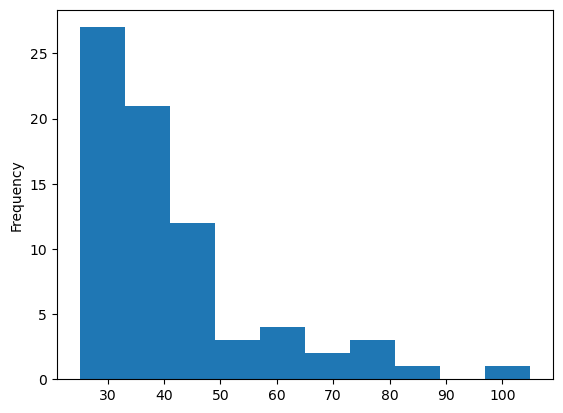

In [7]:
data['turnaround_window'] = data['departure_time'] - data['arrival_time']

# create beautiful histogram for data['turnaround_window']  

data['turnaround_window'].plot(kind='hist')

### Edit Preferred Stand attribut

Since initially we have like almost 30 preferred stand id denoting there would be unique 30 stand, we consider to lower this value, and assign new preferred stand attribute randomly.

In [8]:
random.seed(100)
data['preferredStand'] = data['preferredStand'].apply(lambda x: random.randint(0, 14))

### Edit Preferred Stand Attribute Based on Each Company's Preferences

The following logic and rules are designed to replace the previous code. Instead of setting a preferred stand randomly for all aircraft, the new code will assign a preferred stand ID based on each aircraft's company's specific preferences.

However, we will skip this part for current development. So I will just comment out following codes

In [9]:
# data.Company.value_counts()

In [10]:
# company_1_stand_id = [0,1,2,3,4,5,6]
# company_2_stand_id = [7,8,9,10,11]
# company_3_stand_id = [12,13,14]

## Main Codes

The simulation is written in object oriented approach benefiting SimPy library. We believe that this choice will enhance the intuitiveness in understanding of the codes, as well as its reproducability/reusability. Most importantly, we believe it is better to frame the system we about to model as agent-based system where agents are interacting with each other instead of seeing it as set of discrete events that is occuring. The discrete events are still there but wrapping them inside classes of agents will certainly adding importance to the context.

Below are UML class diagram of the current development of the model (note that this diagram will be periodically updated, improved, depends on which development version you are reading). 

At the moment, we are working on version 1.0


![UML_Class_Diagram](UML_Class_Diagram/ver_1.0.png)

### Main Object-Oriented Codes (The Simulation Codes)

In [57]:
class Stand:
    
    """
    Represents a stand in an airport.

    Attributes:
        stand_id (int): The ID of the stand.
        distance (float): The distance of the stand from a reference point.
    """

    def __init__(self, stand_id, distance):
        self.stand_id = stand_id
        self.distance = distance

class Aircraft:
    def __init__(self, env, name, id, pref_stand_id):
        self.env = env
        self.name = name
        self.pref_stand_id = pref_stand_id
        self.id = id

    def perform_turnaround(self, ground_handler, distance):
        with ground_handler.request() as req:
            yield req
            # Time to travel to the stand
            yield self.env.timeout(distance)
            # Time for the turnaround
            yield self.env.timeout(random.normalvariate(20, 3))
            # Time to travel back to the workcentre
            yield self.env.timeout(distance)

    def get_stand(self, stands, ground_handler):
        start_turnaround = self.env.now
        
        # Looking for and retrieving stand
                
        def is_stand_available(stands, pref_stand_id):
            return any(stand.stand_id == pref_stand_id for stand in stands.items)
        
        if is_stand_available(stands, self.pref_stand_id): 
            # Request a specific stand
            req = stands.get(lambda stand: stand.stand_id == self.pref_stand_id)
            stand = yield req
        else:
            # If the specific stand is not available, take any available stand
            req = stands.get()
            stand = yield req
            
        print(f"{self.env.now} - {self.name}: Arrived at stand {stand.stand_id}")
        
        # Turnaround begins
        yield self.env.process(self.perform_turnaround(ground_handler, stand.distance))
        print(f"{self.env.now} - {self.name}: Departed from stand {stand.stand_id}")
        
        # Pushback aircraft and releasing stand
        yield stands.put(stand)
        flight_delay.append(self.env.now - data['departure_time'][self.id]) 
        turnaround_times.append(self.env.now - start_turnaround )    


def aircraft_generator(env, stands, ground_handler):
    i = 0
    while i <= 73:
        t = data['interarrival_time'][i]
        yield env.timeout(t)
        pref_stand_id = data['preferredStand'][i]
        aircraft = Aircraft(env, name=f"Aircraft {i}", id=i, pref_stand_id=pref_stand_id)
        env.process(aircraft.get_stand(stands, ground_handler))
        i += 1

def monitor_utilization(env, stands, utilization_log, interval=1):
    while True:
        utilization = stands.capacity - len(stands.items)
        utilization_log.append((env.now, utilization / stands.capacity))
        utilization_over_time.append(utilization)
        yield env.timeout(interval)




### Code to Run The Simulation & Setting Parameters Input and Variable Output

In [58]:
# Set up the environment and resources
env = simpy.Environment()
stands = simpy.FilterStore(env, capacity=15)
ground_handler = simpy.Resource(env, capacity=4)

# Initialize stands with specific IDs and distances
distances = [2, 3, 5, 3, 2, 5, 1, 3, 6, 3, 4, 5, 8, 4, 2]
for i in range(15):
    stands.put(Stand(stand_id=i, distance=distances[i]))

# List to store some important variables
utilization_log = []
flight_delay = []
turnaround_times = []
utilization_over_time = []

# Start processes
env.process(aircraft_generator(env, stands, ground_handler))
env.process(monitor_utilization(env, stands, utilization_log))

# Run the simulation
env.run(until=60 * 18) # from 6 in the morning until midnight

mean_utilization = np.mean([utilization for _, utilization in utilization_log])

65.0 - Aircraft 0: Arrived at stand 2
65.0 - Aircraft 1: Arrived at stand 7
65.0 - Aircraft 2: Arrived at stand 0
70.0 - Aircraft 3: Arrived at stand 12
85.0 - Aircraft 4: Arrived at stand 1
85.0 - Aircraft 5: Arrived at stand 11
90.0 - Aircraft 6: Arrived at stand 6
91.72967476322428 - Aircraft 2: Departed from stand 0
92.96883171364144 - Aircraft 1: Departed from stand 7
95.0 - Aircraft 7: Arrived at stand 3
95.0 - Aircraft 8: Arrived at stand 5
96.7526840284827 - Aircraft 0: Departed from stand 2
105.0 - Aircraft 9: Arrived at stand 4
105.970054088656 - Aircraft 3: Departed from stand 12
110.0 - Aircraft 10: Arrived at stand 8
111.31915703931739 - Aircraft 4: Departed from stand 1
115.0 - Aircraft 11: Arrived at stand 12
115.0 - Aircraft 12: Arrived at stand 1
115.0 - Aircraft 13: Arrived at stand 9
115.34155563963493 - Aircraft 6: Departed from stand 6
120.0 - Aircraft 14: Arrived at stand 10
126.5532192579767 - Aircraft 5: Departed from stand 11
130.0 - Aircraft 15: Arrived at sta

### Scenario Bank

1. Allocating aircraft to empty stand if the preferred one is occupied (empty by stand index order) 

In [ ]:
    # def get_stand(self, stands, ground_handler):
    #     start_turnaround = self.env.now
        
    #     # Looking for and retrieving stand
                
    #     def is_stand_available(stands, pref_stand_id):
    #         return any(stand.stand_id == pref_stand_id for stand in stands.items)
        
    #     if is_stand_available(stands, self.pref_stand_id): 
    #         # Request a specific stand
    #         req = stands.get(lambda stand: stand.stand_id == self.pref_stand_id)
    #         stand = yield req
    #     else:
    #         # If the specific stand is not available, take any available stand
    #         req = stands.get()
    #         stand = yield req
            
    #     print(f"{self.env.now} - {self.name}: Arrived at stand {stand.stand_id}")
        
    #     # Turnaround begins
    #     yield self.env.process(self.perform_turnaround(ground_handler, stand.distance))
    #     print(f"{self.env.now} - {self.name}: Departed from stand {stand.stand_id}")
        
    #     # Pushback aircraft and releasing stand
    #     yield stands.put(stand)
    #     flight_delay.append(self.env.now - data['departure_time'][self.id]) 
    #     turnaround_times.append(self.env.now - start_turnaround )   

2. Allocating aircraft only to their preferred stand even though that will mean it will wait if occupied

In [ ]:
    # def get_stand(self, stands, ground_handler):
        
    #     start_turnaround = self.env.now
        
        
    #     req = stands.get(lambda stand: stand.stand_id == self.pref_stand_id)
    
    #     stand = yield req
            
    #     print(f"{self.env.now} - {self.name}: Arrived at stand {stand.stand_id}")
        
    #     # Turnaround begins
    #     yield self.env.process(self.perform_turnaround(ground_handler, stand.distance))
    #     print(f"{self.env.now} - {self.name}: Departed from stand {stand.stand_id}")
        
    #     # Pushback aircraft and releasing stand
    #     yield stands.put(stand)
    #     flight_delay.append(self.env.now - data['departure_time'][self.id]) 
    #     turnaround_times.append(self.env.now - start_turnaround ) 

## Result

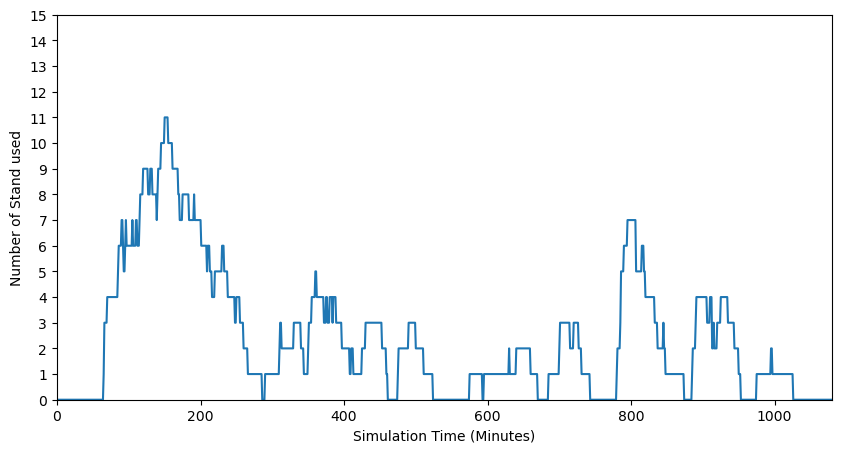

Serviced Aircraft: 74
Mean Utilization: 0.16


In [59]:
plt.figure(figsize=(10,5))
sns.lineplot(utilization_over_time)
plt.ylim(0, 15) # 15 as total stand
plt.xlim(0, 60*18) # 60*15 is total simulation time
plt.ylabel('Number of Stand used')
plt.xlabel('Simulation Time (Minutes)')
plt.yticks(np.arange(0,16,1))
plt.show()

print(f'Serviced Aircraft: {len(flight_delay)}')
print(f"Mean Utilization: {mean_utilization:.2f}")

Note: Mean Utilization is represented by the ratio of area under the line chart over the entire area of the plot. This means that the area above the line chart would be the unused capacity of the stand resources

In [60]:
# convert flight_delay list to dataframe

flight_delay_df = pd.DataFrame(flight_delay)

number_delayed_flights = len(flight_delay_df[flight_delay_df[0] > 0])
number_non_delayed_flights = len(flight_delay_df[flight_delay_df[0] <= 0])


# filter flight_delay_df with positive values

print('Number of delayed flights:', number_delayed_flights)
print('Number of non-delayed flights:', number_non_delayed_flights )
print('Delayed Flights Ratio:', round(number_delayed_flights / (number_delayed_flights + number_non_delayed_flights) * 100, 2), '%')

print('Average delayed flights (minutes):', round(flight_delay_df[flight_delay_df[0] > 0].mean().values[0], 2) )

Number of delayed flights: 26
Number of non-delayed flights: 48
Delayed Flights Ratio: 35.14 %
Average delayed flights (minutes): 13.46


### Analysis: Turnaround Duration

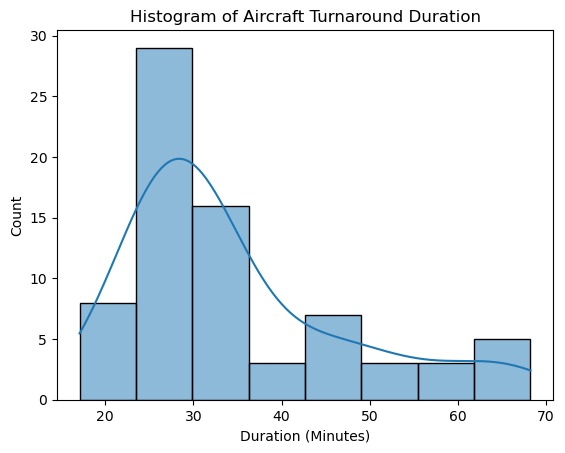

In [61]:
sns.histplot(turnaround_times, kde=True)
plt.xlabel('Duration (Minutes)')
plt.title('Histogram of Aircraft Turnaround Duration')
plt.show()

In [62]:
flight_delay_df['turnaround_duration'] = turnaround_times
flight_delay_df['remark'] = flight_delay_df[0].apply(lambda x: 'On-Time' if x <= 0  else 'Late')

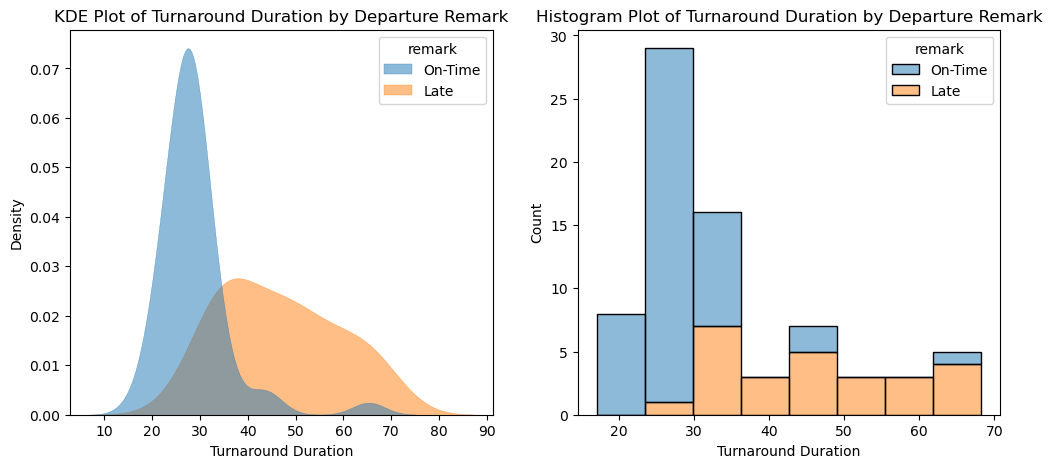

<Figure size 640x480 with 0 Axes>

In [63]:
fig, axes = plt.subplots(1,2, figsize=(12,5))

sns.kdeplot(data=flight_delay_df, x='turnaround_duration', hue='remark', common_norm=False, fill=True, alpha=.5, linewidth=0.2, ax=axes[0])
axes[0].set_xlabel('Turnaround Duration')
axes[0].set_ylabel('Density')
axes[0].set_title('KDE Plot of Turnaround Duration by Departure Remark')



sns.histplot(data=flight_delay_df, x='turnaround_duration', hue='remark', common_norm=False, bins='auto', alpha=0.5, multiple='stack', ax=axes[1])
axes[1].set_xlabel('Turnaround Duration')
axes[1].set_ylabel('Count')
axes[1].set_title('Histogram Plot of Turnaround Duration by Departure Remark')



plt.show()

plt.tight_layout()

## Comparing scenarios results

**Instructions in running different scenarios**

+ Configure the main codes, make sure it embodies the first scenario configuration,
+ Run the simulation, make sure to run also all codes within the 'Results' section
+ Run cell below which noted as Scenario 1 Results Collection (do not run cells it follows)
+ Go back above, and reconfigure the main codes, now set your second scenario configuration
+ Run the simultion again, make sure to run also all codes within the 'Results' section
+ Run cell below which noted as Scenario 2 Results Collection ( do not run previous scenario 1 result cell)
+ Run the subsequent codes below that cells to begin Comparison Analysis


### Scenario 1 Result Collection

In [56]:
# Scenario 1 result

scenario_1_turnaround_time = turnaround_times
scenario_1_number_delayed_flights = number_delayed_flights
scenario_1_number_non_delayed_flights = number_non_delayed_flights
scenario_1_delayed_flight_ratio = (round(scenario_1_number_delayed_flights / (scenario_1_number_delayed_flights + scenario_1_number_non_delayed_flights) * 100, 2), '%')
scenario_1_average_flight_delay_minutes = round(flight_delay_df[flight_delay_df[0] > 0].mean().values[0], 2)


C:\Users\Zak\AppData\Local\Temp\ipykernel_18012\213788526.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  scenario_1_average_flight_delay_minutes = round(flight_delay_df[flight_delay_df[0] > 0].mean().values[0], 2)


### Scenario 2 Result Collection

In [64]:
# Scenario 2 result

scenario_2_turnaround_time = turnaround_times
scenario_2_number_delayed_flights = number_delayed_flights
scenario_2_number_non_delayed_flights = number_non_delayed_flights
scenario_2_delayed_flight_ratio = (round(scenario_2_number_delayed_flights / (scenario_2_number_delayed_flights + scenario_2_number_non_delayed_flights) * 100, 2), '%')
scenario_2_average_flight_delay_minutes = round(flight_delay_df[flight_delay_df[0] > 0].mean().values[0], 2)


C:\Users\Zak\AppData\Local\Temp\ipykernel_18012\688598483.py:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  scenario_2_average_flight_delay_minutes = round(flight_delay_df[flight_delay_df[0] > 0].mean().values[0], 2)


### Comparison Analysis

In [65]:
scenario_results_data = {
    'item': ['Number of Delayed Flights', 'Number of Non-Delayed Flights', 'Delayed Flight Ratio', 'Average Flight Delay (Minutes)'],
    'Scenario 1': [scenario_1_number_delayed_flights, scenario_1_number_non_delayed_flights, scenario_1_delayed_flight_ratio, scenario_1_average_flight_delay_minutes],
    'Scenario 2': [scenario_2_number_delayed_flights, scenario_2_number_non_delayed_flights, scenario_2_delayed_flight_ratio, scenario_2_average_flight_delay_minutes]
}

# Create the DataFrame
comparison_df = pd.DataFrame(scenario_results_data)
comparison_df

,item,Scenario 1,Scenario 2
0,Number of Delayed Flights,31,26
1,Number of Non-Delayed Flights,43,48
2,Delayed Flight Ratio,"(41.89, %)","(35.14, %)"
3,Average Flight Delay (Minutes),20.53,13.46


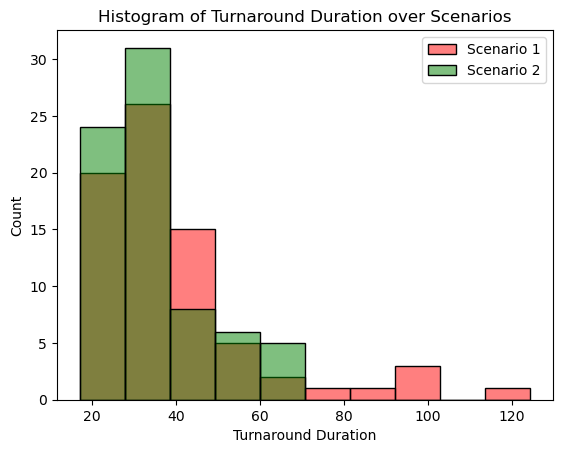

Scenario 1 Average Turnaround Duration: 39.98
Scenario 2 Average Turnaround Duration: 34.92


In [67]:
# Set the number of bins
num_bins = 10

# Determine the bin edges
min_edge = min(min(scenario_1_turnaround_time), min(scenario_2_turnaround_time))
max_edge = max(max(scenario_1_turnaround_time), max(scenario_2_turnaround_time))
bin_edges = np.linspace(min_edge, max_edge, num_bins + 1)

# Plot the histograms with the same bin edges
sns.histplot(scenario_1_turnaround_time, bins=bin_edges, kde=False, color='red', alpha=0.5, label='Scenario 1')
sns.histplot(scenario_2_turnaround_time, bins=bin_edges, kde=False, color='green', alpha=0.5, label='Scenario 2')

# Add labels and title
plt.xlabel('Turnaround Duration')
plt.ylabel('Count')
plt.title('Histogram of Turnaround Duration over Scenarios')

# Add legend
plt.legend()

# Show the plot
plt.show()

print('Scenario 1 Average Turnaround Duration:', round(np.average(scenario_1_turnaround_time),2))
print('Scenario 2 Average Turnaround Duration:', round(np.average(scenario_2_turnaround_time),2))